# Pytorch: modules

In the previous notebook, we have laboriously trained a neural network written by hand. Pytorch actually contains many modules that make the definition of a network, the data collection and the training very easy.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Neural network module

The `torch.nn` module allows to easily define complicated networks. It implements basic linear and convolutional layers, and allows to build with them easily. To do so, we define a `nn.Module` class.

This class has two methods:

* `__init__` specifies the different layers of the network
* `forward` defines how to go from the input to the output using the layers defined in the init.

For instance, this is how you would define a simple neural network with one hidden layer of size $100$, that takes $10$ inputs and returns $3$ outputs:

In [3]:
class Two_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(10, 100)
        self.layer2 = nn.Linear(100, 3)

    def forward(self, x):
        y = self.layer1(x)
        y = torch.tanh(y)
        y = self.layer2(y)
        return y

net = Two_layers()

In [4]:
x = torch.randn(1000, 10)
net(x)

tensor([[ 0.0041, -0.2475,  0.1184],
        [-0.0224,  0.2300,  0.0574],
        [-0.0351, -0.1890, -0.0986],
        ...,
        [ 0.0669,  0.3171, -0.2704],
        [-0.2794, -0.0120, -0.1264],
        [ 0.2799, -0.0378, -0.3819]], grad_fn=<AddmmBackward0>)

# Optim module

The `torch.optim` module then allows to easily learn the parameters of the net with backprop. An optimizer, like SGD, takes the parameters of the network as input.

In [5]:
import torch.optim as optim

optimizer = optim.SGD(lr=1e-2, params=net.parameters())

We can then compute a (toy) loss, backpropagate, and use the `optimizer.step` method to make an update:

In [6]:
optimizer.zero_grad()
y = net(x)
loss = y.sum()
loss.backward()
optimizer.step()

And that is it !

# Datasets
There are also some convenient tools to load datasets. For instance, we will work with MNIST:

In [7]:
from torchvision import datasets, transforms

Let's download the MNIST dataset, the train and testing data, and apply a simple normalizing transform.

In [8]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 393508161.02it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 96676531.38it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 63815042.32it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3672745.09it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



We can then define a loader that will automatically load the images when we train / test

In [9]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

We can then loop over these loaders to get the images:

torch.Size([128, 1, 28, 28])
torch.Size([128])


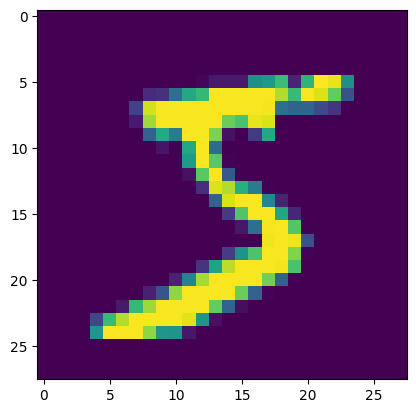

In [10]:
import matplotlib.pyplot as plt

for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    plt.imshow(x[0, 0])
    break

We are now ready to train a network on MNIST !

# Training on MNIST

**Exercise 1**: Define a one hidden neural network for MNIST, with a hidden layer of size $1000$.

In [11]:
class Two_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(28 * 28, 1000)
        self.layer2 = nn.Linear(1000, 10)
    def forward(self, x):
      y = x.view(len(x), -1)
      y = self.layer1(y)
      y = torch.tanh(y)
      y = self.layer2(y)
      return y

net = Two_layers()

In [12]:
for x, y in train_loader:
  print(x.shape)
  print(net(x))
  break

torch.Size([128, 1, 28, 28])
tensor([[-0.2577,  0.0585,  0.1305,  ..., -0.3366, -0.0228, -0.0459],
        [-0.0023, -0.3232, -0.1326,  ..., -0.0692, -0.0180,  0.1610],
        [-0.1068, -0.2859, -0.0671,  ...,  0.2190, -0.1777, -0.0940],
        ...,
        [-0.2381, -0.0730, -0.1607,  ...,  0.0960, -0.0470,  0.0843],
        [-0.1789,  0.0735,  0.2717,  ...,  0.1989, -0.1096,  0.1145],
        [-0.1013, -0.2980,  0.1039,  ..., -0.2059, -0.1296, -0.1760]],
       grad_fn=<AddmmBackward0>)


**Exercise 2** : Define an SGD optimizer for this network

In [13]:
optimizer = optim.SGD(lr=1e-2, params=net.parameters())

**Exercise 3**: Perform one training epoch on the data, and compute the testing accuracy. Use the cross entropy as loss.

In [14]:
from torch.nn.functional import cross_entropy
from tqdm import tqdm

In [15]:
for i, (x, y) in tqdm(enumerate(train_loader)):
  optimizer.zero_grad()
  output = net(x)
  loss = cross_entropy(output, y)
  loss.backward()
  optimizer.step()

469it [00:18, 25.99it/s]


In [16]:
good_preds = 0
for x, y in test_loader:
    pred = net(x)
    good_preds += (pred.argmax(axis=1) == y).sum().item()

print(good_preds / 10000)

0.898


You should get ~ 90% accuracy.

**Exercise 4**: Now, train a convolutionnal network, and try to get the best accuracy.

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(1, 10, 3, padding=1)
        self.maxpool1 = nn.MaxPool2d(2)
        self.layer2 = nn.Conv2d(10, 20, 3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2)
        self.layer3 = nn.Conv2d(20, 30, 3, padding=1)
        self.maxpool3 = nn.MaxPool2d(2)
        self.layer4 = nn.Conv2d(30, 1000, 3, padding=1)
        self.maxpool4 = nn.MaxPool2d(2)
        self.linear = nn.Linear(1000, 10)
    def forward(self, x):
        y = self.maxpool1(self.layer1(x))
        y = self.maxpool2(self.layer2(y))
        y = self.maxpool3(self.layer3(y))
        y = self.maxpool4(self.layer4(y))
        y = y.view(len(y), -1)
        y = self.linear(y)
        return y

net = CNN()

for x, y in train_loader:
    print(net(x))
    break

tensor([[ 0.1323, -0.0208, -0.0313,  ...,  0.1496, -0.1145, -0.0192],
        [ 0.1257,  0.0620, -0.0280,  ...,  0.1855, -0.1477,  0.0280],
        [ 0.0800,  0.0434, -0.0522,  ...,  0.1293, -0.1325,  0.0724],
        ...,
        [ 0.1160,  0.0062, -0.0541,  ...,  0.2037, -0.1885,  0.0012],
        [ 0.0563,  0.0055, -0.1112,  ...,  0.1756, -0.2019,  0.0003],
        [ 0.0725,  0.0292, -0.1088,  ...,  0.1952, -0.1297,  0.0959]],
       grad_fn=<AddmmBackward0>)


In [18]:
optimizer = optim.Adam(lr=1, params = net.parameters())
for i, (x, y) in tqdm(enumerate(train_loader)):
    optimizer.zero_grad()
    output = net(x)
    loss = cross_entropy(output, y)
    loss.backward()
    optimizer.step()


469it [00:52,  8.90it/s]


In [19]:
good_preds = 0
for x, y in test_loader:
    pred = net(x)
    good_preds += (pred.argmax(axis=1) == y).sum().item()

print(good_preds / 10000)

0.9464


**Exercise 5**: Put this model on a GPU, and compare the training time.
To put a model to GPU, you can to `net.to('cuda')`. The data `x` and `y`should also be put on the GPU.

In [20]:
torch.cuda.is_available()

True

In [29]:
net = CNN().to('cuda')
optimizer = optim.Adam(lr=1, params = net.parameters())
for i, (x, y) in tqdm(enumerate(train_loader)):
  x = x.to('cuda')
  y = y.to('cuda')
  optimizer.zero_grad()
  output = net(x)
  loss = cross_entropy(output, y)
  loss.backward()
  optimizer.step()

469it [00:16, 28.46it/s]


In [30]:
good_preds = 0
for x, y in test_loader:
  x = x.to('cuda')
  y = y.to('cuda')
  pred = net(x)
  good_preds += (pred.argmax(axis=1) == y).sum().item()

print(good_preds / 10000)

0.9416
